# Step 1 - Explore the Algorithm

In this notebook you will get an overview of the reinforcement learning algorithm being used for this experiment and the implementation of distributed learning. This is not a tutorial on the basics of reinforcement learning - for a good introduction to the basics, see [this tutorial](https://medium.freecodecamp.org/deep-reinforcement-learning-where-to-start-291fb0058c01). Our algorithm is modeled after [this deep Q-learning algorithm from Google DeepMind](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf) which has seen success in learning to play Atari video games.

If you are just looking to run the model training without exploring the algorithm, you can skip ahead to **[Step 2 - Launch the Training Job](LaunchTrainingJob.ipynb)** if you are running this on a cluster or **[Step 2A: Launch Local Training Job](LaunchLocalTrainingJob.ipynb)** if you are running this locally.

At this point, **[please start the AirSim executable](README.md#simulator-package)** on your local machine as the code presented in this notebook needs to connect to the executable to generate images. 

First, let's import some libraries.

In [4]:
import sys
print(sys.executable)

/home/yunhs139/.conda/envs/airsim_drl/bin/python


In [5]:
import matplotlib
print(matplotlib.__version__)
print(matplotlib.__file__)

3.5.3
/home/yunhs139/.conda/envs/airsim_drl/lib/python3.10/site-packages/matplotlib/__init__.py


In [1]:
%matplotlib inline
from Share.scripts_downpour.app.airsim_client import *
import numpy as np
import time
import sys
import json
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
import PIL
import PIL.ImageFilter

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model, clone_model, load_model
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Lambda, Input, concatenate
#from keras.layers.normalization import BatchNormalization
from keras.layers import BatchNormalization 
#from keras.layers.advanced_activations import ELU
from keras.layers import ELU
from keras.optimizers import Adam, SGD, Adamax, Nadam, Adagrad, Adadelta
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, CSVLogger, EarlyStopping
import keras.backend as K
from keras.preprocessing import image
from keras.initializers import random_normal

2025-05-20 07:08:45.821103: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-20 07:08:45.853299: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-20 07:08:45.853340: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-20 07:08:45.853385: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-20 07:08:45.860939: I tensorflow/core/platform/cpu_feature_g

## The reward function

One of the critical decisions to make when desigining a reinforcement learning experiment is the definition of the reward function. For this tutorial, we define a very simple reward function which only takes into account the position of the car. In the experiment, the optimal position for our car is the center of the road, so we want to assign a high reward when the car is in the center, and a low reward when it is closer to the edge. We also want our reward function to be bounded in the range [0, 1] as it will be easier for our model to learn values within that range.

> **Thought Exercise 1.1:** 
As you will soon see, the reward function defined here is very basic and doesn't take into account some important parameters. Can you point out some obvious considerations this reward function overlooks?

> **Thought Exercise 1.2:** 
The next time you are out for a drive, take note of how things happening around you on the road (the behavoir of other vehicles and pedestrians, traffic laws, roadsigns etc), the state of your car (your current speed, steering angle, acceleration etc) and your mental state (the urgency of getting to your destination, your overall stress/frustration level etc) result in you making decisions on the road. Reinforcement learning is unique as it is inspired by the behavioral psychology of human beings and animals. If you were to write a reward function for how you drive in real life, what would it look like?

To compute our reward function, we begin by computing the distance to the center of the nearest road. We then pass that distance through an exponential weighting function to force this portion to the range [0, 1]. The full definition of the reward function can be seen below.

In [2]:
def compute_reward(car_state, collision_info, road_points):
    #Define some constant parameters for the reward function
    THRESH_DIST = 3.5                # The maximum distance from the center of the road to compute the reward function
    DISTANCE_DECAY_RATE = 1.2        # The rate at which the reward decays for the distance function
    CENTER_SPEED_MULTIPLIER = 2.0    # The ratio at which we prefer the distance reward to the speed reward
    
    # If the car is stopped, the reward is always zero
    speed = car_state.speed
    if (speed < 2):
        return 0
    
    #Get the car position
    position_key = bytes('position', encoding='utf8')
    x_val_key = bytes('x_val', encoding='utf8')
    y_val_key = bytes('y_val', encoding='utf8')

    car_point = np.array([car_state.kinematics_true[position_key][x_val_key], car_state.kinematics_true[position_key][y_val_key], 0])
    
    # Distance component is exponential distance to nearest line
    distance = 999
    
    #Compute the distance to the nearest center line
    for line in road_points:
        local_distance = 0
        length_squared = ((line[0][0]-line[1][0])**2) + ((line[0][1]-line[1][1])**2)
        if (length_squared != 0):
            t = max(0, min(1, np.dot(car_point-line[0], line[1]-line[0]) / length_squared))
            proj = line[0] + (t * (line[1]-line[0]))
            local_distance = np.linalg.norm(proj - car_point)
        
        distance = min(distance, local_distance)
        
    distance_reward = math.exp(-(distance * DISTANCE_DECAY_RATE))
    
    return distance_reward

To visualize how our reward function works, we can plot the car state and print the reward function. In the figure below, the black lines are the precomputed centers of each road, and the blue dot is the current position of the car. At the intersections, we define a few possible paths that the car can take. As you drive the car around (using the keyboard), you will see the reward function change.

In [3]:
plt.figure()
   
# Reads in the reward function lines
def init_reward_points():
    road_points = []
    with open('Share/data/reward_points.txt', 'r') as f:
        for line in f:
            point_values = line.split('\t')
            first_point = np.array([float(point_values[0]), float(point_values[1]), 0])
            second_point = np.array([float(point_values[2]), float(point_values[3]), 0])
            road_points.append(tuple((first_point, second_point)))

    return road_points

#Draws the car location plot
def draw_rl_debug(car_state, road_points):
    fig = plt.figure(figsize=(15,15))
    print('')
    for point in road_points:
        plt.plot([point[0][0], point[1][0]], [point[0][1], point[1][1]], 'k-', lw=2)
    
    position_key = bytes('position', encoding='utf8')
    x_val_key = bytes('x_val', encoding='utf8')
    y_val_key = bytes('y_val', encoding='utf8')
    
    car_point = np.array([car_state.kinematics_true[position_key][x_val_key], car_state.kinematics_true[position_key][y_val_key], 0])
    plt.plot([car_point[0]], [car_point[1]], 'bo')
    
    plt.show()
    
reward_points = init_reward_points()
    
car_client = CarClient()
car_client.confirmConnection()
car_client.enableApiControl(False)

try:
    while(True):
        clear_output(wait=True)
        car_state = car_client.getCarState()
        collision_info = car_client.getCollisionInfo()
        reward = compute_reward(car_state, collision_info, reward_points)
        print('Current reward: {0:.2f}'.format(reward))
        draw_rl_debug(car_state, reward_points)
        time.sleep(1)

#Handle interrupt gracefully
except:
    pass

TypeError: unsupported operand type(s) for *: 'AsyncIOLoop' and 'float'

<Figure size 640x480 with 0 Axes>

## Network architecture and transfer learning

Our model uses images from the front facing webcam as input. As we did in our end-to-end model, we select a small sub-portion of the image to feed to the model. This reduces the number of parameters in our model, making it train faster.

The code below will take an image from AirSim, apply the preprocessing functions, and display it below.

Waiting for connection: 


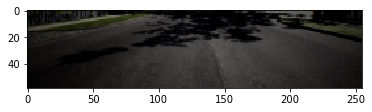

In [6]:
def get_image(car_client):
        image_response = car_client.simGetImages([ImageRequest(0, AirSimImageType.Scene, False, False)])[0]
        image1d = np.frombuffer(image_response.image_data_uint8, dtype=np.uint8)
        image_rgba = image1d.reshape(image_response.height, image_response.width, 4)

        return image_rgba[76:135,0:255,0:3]

car_client = CarClient()
car_client.confirmConnection()
image = get_image(car_client)

image = plt.imshow(image) 

We utilize a very similar network architecture to the one used in our [end-to-end deep learning tutorial](https://github.com/Microsoft/AutonomousDrivingCookbook/tree/master/AirSimE2EDeepLearning) with three convolution layers. The input to the network is a single image frame taken from the front-facing webcam. The output is the predicted Q values for each of the possible actions that the model can take. The full network architecture is defined in the code snippet below.

You can go about the training process in one of two ways. You can train your model ground up, which would mean you will kick off your training with random weights and see random behavior in your car as it tries to learn how to steer itself on the road. This random behaviour will eventually turn into more expected behavior and you will be able to see the car learn how to make turns and and stay on the road. This could take up days to train however.

You could take a diferrent approach to speed things up a little bit though. Using a technique called [Transfer Learning](https://journalofbigdata.springeropen.com/articles/10.1186/s40537-016-0043-6) you can leverage knowledge from a model you  trained previously and apply it to this model. Transfer learning works on a very simple concept: using existing knowledge to learn new related things instead of learning them from scratch. The technique has become very popular for tasks like image classification where instead of training image classifiers from scratch for a given use case (which can require a very large amount of data), you take learned features from an existing network (VGGNet, ResNet, GoogleNet etc) and fine tune them to your use case using a much smaller amount of data.

Luckily for us, we already have a model that learned how to steer itself on the road (see the [end-to-end deep learning tutorial](https://github.com/Microsoft/AutonomousDrivingCookbook/tree/master/AirSimE2EDeepLearning)). Even though we trained that model in a different simulation environment, the mechanics of data collection remain the same. The two tasks are quite similar which makes this a perfect candidate for transfer learning. If you decide to go the transfer learning route, you will notice that the initial behaviour of the car is much less random. It still won't drive perfectly since one, our end-to-end model was not the best possible version of itself to begin with, and two, it has never seen elements like other cars, houses etc. in its environment which throw it off. This is still much better than starting from scratch though, and you will see that this technique will help your model converge much faster.

In [7]:
activation = 'relu'

# The main model input.
pic_input = Input(shape=(59,255,3))
train_conv_layers = False # For transfer learning, set to True if training ground up.

img_stack = Conv2D(16, (3, 3), name='convolution0', padding='same', activation=activation, trainable=train_conv_layers)(pic_input)
img_stack = MaxPooling2D(pool_size=(2,2))(img_stack)
img_stack = Conv2D(32, (3, 3), activation=activation, padding='same', name='convolution1', trainable=train_conv_layers)(img_stack)
img_stack = MaxPooling2D(pool_size=(2, 2))(img_stack)
img_stack = Conv2D(32, (3, 3), activation=activation, padding='same', name='convolution2', trainable=train_conv_layers)(img_stack)
img_stack = MaxPooling2D(pool_size=(2, 2))(img_stack)
img_stack = Flatten()(img_stack)
img_stack = Dropout(0.2)(img_stack)

img_stack = Dense(128, name='rl_dense', kernel_initializer=random_normal(stddev=0.01))(img_stack)
img_stack=Dropout(0.2)(img_stack)
output = Dense(5, name='rl_output', kernel_initializer=random_normal(stddev=0.01))(img_stack)

opt = Adam()
action_model = Model(inputs=[pic_input], outputs=output)

action_model.compile(optimizer=opt, loss='mean_squared_error')
action_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 59, 255, 3)        0         
_________________________________________________________________
convolution0 (Conv2D)        (None, 59, 255, 16)       448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 127, 16)       0         
_________________________________________________________________
convolution1 (Conv2D)        (None, 29, 127, 32)       4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 63, 32)        0         
_________________________________________________________________
convolution2 (Conv2D)        (None, 14, 63, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 31, 32)         0         
__________

Now that you have an understanding of the algorithm details, you are ready to move on to **[Step 2 - Launch the Training Job](LaunchTrainingJob.ipynb)** if you are running this on a cluster or **[Step 2A: Launch Local Training Job](LaunchLocalTrainingJob.ipynb)** if you are running this locally.